<a href="https://csdms.colorado.edu"><img style="float: center; width: 75%" src="(https://lab.openearthscape.org/hub/user-redirect/lab/tree/abrupt-perturbations/abrupt_fire_landslide/media/logo.png)"></a>

# Landlab - using the LandslideProbability component to compute a landslide probability for each cell of a landscape.
## (a) Landscape initiation.

First we create a artificial grid (this will be replaced by real SRTM grid from Oregon).

In [6]:
from landlab import RasterModelGrid
rowNb = 10; colNb = 10; cellSpacing = (30, 30) # in meters
grid = RasterModelGrid((rowNb, colNb), xy_spacing=cellSpacing)


We add an elevation field populated with 0-m elevation.

In [39]:
# create elevation field filled with zeros # REMOVE the clobber=True for the final code
# note that topographic elevation should be in a field called "topographic__elevation" to be later used by other components
z = grid.add_zeros('topographic__elevation', at = 'node', clobber=True)
grid.field_values('topographic__elevation')
z[grid.y_of_node>150] += 10

We display the landscape.

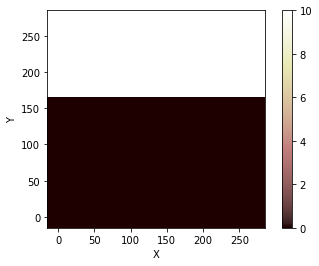

In [40]:
# now display the landscape
from landlab import imshow_grid
imshow_grid(grid, 'topographic__elevation')

## (b) Get information on the LandslideProbability component.
Then before we instantiate the LandslideProbability component, we check the possible input variables.

In [41]:
from landlab.components.landslides import LandslideProbability
sorted(LandslideProbability.input_var_names)

['soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area']

We can check the units of these variables.

In [42]:
LandslideProbability.var_units('topographic__specific_contributing_area')

'm'

We can also get more details about how the input variable will be used in the component.

In [43]:
LandslideProbability.var_help('soil__transmissivity')

name: soil__transmissivity
description:
  mode rate of water transmitted through a unit width of saturated
  soil - either provided or calculated with Ksat and soil depth
units: m2/day
unit agnostic: False
at: node
intent: in


## (c) Fill the landscape grid with the soil variables the LandslideProbability component needs to work.
_Details on where to find readily available data and how to process these data into parameter rasters are provided in Strauch et al., (2018). For example, root cohesion can be generated from reclassifying land use/land cover (LULC) rasters from USGS National Land Cover Data (USGS 2014; Jin 2013) 
based on reference to a lookup table that specifies the root cohesion for different LULC types, Table 1 in Strauch et al., (2018). The reclassified raster can then be converted to an ASCII file for import into Landlab, defined with number of rows and columns and cell size._

Here we'll make things the simplest as possible. Soil is dominantly sandy in the selected area.

We suppose a homogeneous soil density. Density should evolve with precipitation and drought (and fires?).

In [44]:
import numpy as np

soilDensityArr = 1800 * np.ones(grid.number_of_nodes) # kg/m3
grid.add_field('soil__density', soilDensityArr, at='node', clobber=True) 
# clobber allows to delete existing field before re-creation
grid.field_values('soil__density')

array([ 1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,
        1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,
        1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,
        1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,
        1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,
        1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,
        1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,
        1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,
        1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,
        1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,
        1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,
        1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,  1800.,
        1800.,  1800.,  1800.,  1800.])

We also suppose a homogeneous soil internal friction angle. This angle should vary with clay/sand soil content and density. 

In [45]:
soilType = 'sand' # other possibility: clay
soilInternalFrictionAngle = 35 # in degrees
if soilType == 'clay':
    soilInternalFrictionAngle = 10
soilInternalFrictionAngleArr = soilInternalFrictionAngle * np.ones(grid.number_of_nodes)
grid.add_field('soil__internal_friction_angle' , soilInternalFrictionAngleArr, at='node', clobber=True)
grid.field_values('soil__internal_friction_angle')

array([ 35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,
        35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,
        35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,
        35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,
        35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,
        35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,
        35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,
        35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,
        35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,
        35.])

We set the combined **root and soil cohesion**. Some values of soil cohesion can be found here: http://www.geotechdata.info/parameter/cohesion.
We'll make the simplest and take four values, depending of soil type (clayey / sandy, and water saturated depending on dry/wet).
For simplicity, we define the mode, and then add scatter = 0 to get minimum/maximum values.

In [46]:
# Constants of soil cohesion, depending dry or wet
drySoilCohesion = [70000, 20000] # in Pa. 1: more clayey, 2: more sandy 
wetSoilCohesion = [20000, 10000] # in Pa. 1: more clayey, 2: more sandy

# Supposing that soil is wet (occurring during rainfall) and sandy
soilCohesion = wetSoilCohesion[1]
soilCohesionArr = soilCohesion * np.ones(grid.number_of_nodes)
grid.add_field('soil__mode_total_cohesion', soilCohesionArr, at='node', clobber=True) # in Pa

# Maximum and minimum values are copied from mode, for simplicity
grid.add_field('soil__minimum_total_cohesion', grid.field_values('soil__mode_total_cohesion'), at='node', clobber=True) # in Pa
grid.add_field('soil__maximum_total_cohesion', grid.field_values('soil__mode_total_cohesion'), at='node', clobber=True) # in Pa

array([ 10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
        10000.,  100

We define soil thickness. By simplicity same value everywhere, but there should be a little variation with slope (with specifically little soil for slope > 30°).

In [79]:
soilThicknessArr = 0.5 * np.ones(grid.number_of_nodes) # in m
grid.add_field( 'soil__thickness', soilThicknessArr, at='node', clobber=True) # in m

array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5])

We define soil hydraulic conductivity. Varies depending clayey/sandy soil. If this is defined, no use to define transmissivity: ***UNTRUE: the component is raising an error***.

**TODO: Check whether proposed values are realistic. AND recompute soil transmissivity values.**

In [81]:
soilHydraulicConductivity = [1e-5, 1e-3] # in m/day. 1: more clayey, 2: more sandy
soilHydraulicConductivityArr = soilHydraulicConductivity[1] * np.ones(grid.number_of_nodes)
grid.add_field( 'soil__saturated_hydraulic_conductivity', soilHydraulicConductivityArr, at='node', clobber=True) # in m/day
grid.add_field( 'soil__transmissivity', grid.field_values('soil__saturated_hydraulic_conductivity') *
              grid.field_values('soil__thickness') , at='node', clobber=True) # in m2/day

array([ 0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0

## d) Fill the landscape grid with the topographic slope and contributing drainage areas, which are calculated from the DEM supplied with the grid, and which the LandslideProbability component needs to work.
We now compute the slope from the grid DEM supplied to the LandslideProbability.
Doc: https://landlab.readthedocs.io/en/master/reference/grid/gradients.html.

In [78]:
import numpy as np
topographicSlopeArr = grid.calc_slope_at_node(elevs='topographic__elevation')
# I expect that calc_slope_at_node computes the tangent, i.e. the ratio of the vertical to the horizontal side, 
#also called the slope of the line
slopes = grid.add_field('topographic__slope', topographicSlopeArr, at='node', clobber=True) # without units, 
# should be the tangent of slope angle
slopes

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.16087528,  0.16087528,  0.16087528,  0.16087528,  0.16087528,
        0.16087528,  0.16087528,  0.16087528,  0.16087528,  0.16087528,
        0.16087528,  0.16087528,  0.16087528,  0.16087528,  0.16087528,
        0.16087528,  0.16087528,  0.16087528,  0.16087528,  0.16

We now compute the specific contributing area from the grid DEM supplied.
This should be  calculated as upslope drainage area/unit contour length (e.g., grid cell width) using the multiple flow direction D-infinity approach of TauDEM. 
(http://hydrology.usu.edu/taudem/taudem5/index.html).


We first close boundaries except at the north (in the Oregon DEM supplied).

In [ ]:
grid.set_closed_boundaries_at_grid_edges(True, False, True, True) # right is closed, top, left, bottom

We then instantiate and compute the flow accumulator, using the steepest descent.

Doc: https://landlab.readthedocs.io/en/master/reference/components/flow_accum.html?highlight=flow_accum
https://landlab.readthedocs.io/en/master/_modules/landlab/components/flow_accum/flow_accumulator.html

In [70]:
from landlab.components import FlowAccumulator
# Instantiation
fa = FlowAccumulator(
     grid, 'topographic__elevation', flow_director='FlowDirectorSteepest'
)

In [71]:
fa.surface_values

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.])

We then run the flow accumulator once.

In [72]:
fa.run_one_step() # run of the flow accumulator

In [74]:
# Affecting the specific contributing area (drainage basin)
contributingAreas = grid.add_field('topographic__specific_contributing_area', grid.at_node['drainage_area'], at='node', clobber=True) # in m
print(contributingAreas)

[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.   900.   900.   900.   900.   900.   900.   900.   900.     0.
     0.   900.   900.   900.   900.   900.   900.   900.   900.     0.
     0.   900.   900.   900.   900.   900.   900.   900.   900.     0.
     0.   900.   900.   900.   900.   900.   900.   900.   900.     0.
     0.  1800.  1800.  1800.  1800.  1800.  1800.  1800.  1800.     0.
     0.   900.   900.   900.   900.   900.   900.   900.   900.     0.
     0.   900.   900.   900.   900.   900.   900.   900.   900.     0.
     0.   900.   900.   900.   900.   900.   900.   900.   900.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]


## e) Launches the LandslideProbability component needs to work.

In [83]:
ls_prob = LandslideProbability(grid)  # instantiate the component and launch it
np.allclose(grid.at_node['landslide__probability_of_failure'], 0.)

True

In [84]:
grid.at_node['landslide__probability_of_failure']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])